In [7]:
import numpy as np
import pandas as pd
import pickle as pk
import matplotlib as plt
%matplotlib inline
from IPython.display import display, HTML

datapath = 'data/tcd ml 2019-20 income prediction test (without labels).csv'
instances = pd.read_csv(datapath).loc[:, 'Instance']

# source: https://data.worldbank.org/indicator/NY.GDP.MKTP.CD
# The top rows were removed to aid in parsing
gdp = pd.read_csv('data/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_180634.csv', skiprows=[0, 1, 2, 3])

# Prepare data for ml algorithm

In [8]:
# Some helper functions
from sklearn.preprocessing import LabelBinarizer

def clean_country(country):
    try:
        return {
            'Laos': 'Lao PDR',
            'Kyrgyzstan': 'Kyrgyz Republic',
            'Slovakia': 'Slovak Republic',
            'Congo': 'Congo, Rep.',
            'DR Congo': 'Congo, Dem. Rep.',
            # Nothing political intended here, trying to be realistic about income
            'State of Palestine': 'Jordan',
            'Syria': 'Syrian Arab Republic',
            'Gambia': 'Gambia, The',
            'North Korea': 'Korea, Dem. People’s Rep.',
            'South Korea': 'Korea, Rep.',
            'Côte d\'Ivoire': 'Cote d\'Ivoire',
            'Venezuela': 'Venezuela, RB',
            'Yemen': 'Yemen, Rep.',
            'Brunei': 'Brunei Darussalam',
            'Micronesia': 'Micronesia, Fed. Sts.',
            'Bahamas': 'Bahamas, The',
            'Saint Lucia': 'St. Lucia',
            'Czechia': 'Czech Republic',
            'Sao Tome & Principe': 'Sao Tome and Principe',
        }[country]
    except KeyError:
        return country

def get_index_equiv(year):
    return year - 1956

def country_to_gdp(countries):
    return_val = {}
    for country in countries:
        try:
            gdpval = np.nan
            year = 2018
            while np.isnan(gdpval):
                gdpval = gdp.loc[gdp['Country Name'] == clean_country(country)].iloc[:, get_index_equiv(year)].item()
                year -= 1
                if year < 1960:
                    if country == 'North Korea':
                        # There isn't World Bank data for NK, let's assume it's USD32 Billion
                        gdpval = float(32000000000)
                    else:
                        raise IndexError('Could not find GDP')
            return_val[country] = gdpval
        except ValueError:
            print('Country Error, check : clean_country() -> ', country)
    return return_val

def shorten_jobs(jobs, length=8, thresh=80):
    return_val = {}
    for key in jobs:
        if jobs[key] > thresh:
            try:
                new_key = key[:length]
            except TypeError:
                new_key = 'unkn'
        else:
            new_key = 'unkn'
        return_val[key] = new_key
    
    # Make sure that there aren't any duplicates
    for key in return_val:
        try:
            return_val[return_val[key]]
            return_val[key] = 'unkn'
        except KeyError:
            continue
    
    return return_val

def one_hot_encode(data, column):
    degree_encoder = LabelBinarizer()
    degree_encoder.fit(data[column])
    degree_encoder = pk.load(open(column.replace(' ', '_') + '.pkl', mode='rb'))
    transformed = degree_encoder.transform(data[column])
    ohe_df = pd.DataFrame(transformed)
    return pd.concat([data, ohe_df], axis=1).drop([column], axis=1)

In [9]:
def country_to_est_gdp(data):
    return pk.load(open('est_gdp.pkl', mode='rb'))

In [28]:
def process_data(path, 
                 Instance_drop, 
                 Year_of_Record_drop, 
                 Gender_drop, 
                 Age_drop, 
                 Country_drop, 
                 Size_of_City_drop, 
                 Profession_drop, 
                 University_Degree_drop, 
                 Wears_Glasses_drop, 
                 Hair_Color_drop, 
                 Body_Height_cm_drop,
                 prof_len=4,
                 prof_cutoff=80,
                 replace_gdp = True,
                 replace_est_gdp = False,
                 scale_uni = True,
                 drop_income_outlier = True,
                 income_cutoff = 1000000,
                 gdp_cutoff = 1.5*pow(10,12),
):
    from sklearn.preprocessing import LabelBinarizer

    data = pd.read_csv(path)
    data = data.fillna(value=0)

    ## 'Instance'
    print(' * INFO: Processing \'Instance\'')
    if Instance_drop == True:
        data = data.drop(labels='Instance', axis=1)
    else:
        pass

    ## 'Year of Record'
    print(' * INFO: Processing \'Year of Record\'')
    if Year_of_Record_drop == True:
        data = data.drop(labels='Year of Record', axis=1)
    else:
        data = data.replace(to_replace={'Year of Record': {
                0: 2000,
        }})

    ## 'Gender'
    print(' * INFO: Processing \'Gender\'')
    if Gender_drop == True:
        data = data.drop(labels='Gender', axis=1)
    else:
        data = data.replace(to_replace={'Gender': {
                'male': 1,
                'female': -1,
                'other': 0,
                'unknown': 0,
                '0': 0,
                np.nan: 0,
        }})

    ## 'Age'
    print(' * INFO: Processing \'Age\'')
    if Age_drop == True:
        data = data.drop(labels='Age', axis=1)
    else:
        data = data.replace(to_replace={'Age': {
                0: 40,
        }})

    ## 'Country'
    print(' * INFO: Processing \'Country\'')
    assert((replace_gdp != replace_est_gdp) or ((replace_gdp == False) and (replace_est_gdp == False)))
    # Replace country with its GDP
    if Country_drop == True:
        data = data.drop(labels='Country', axis=1)
    else:
        if replace_gdp == True:
            country_gdp = {'Country': country_to_gdp(pd.Series.to_dict(data['Country'].value_counts()))}
            data = data.replace(to_replace=country_gdp)
        elif replace_est_gdp == True:
            country_gdp = {'Country': country_to_est_gdp(data)}
            data = data.replace(to_replace=country_gdp)
            data = data.replace(to_replace={'Country': {
                'Iceland': 486262.74,
                'Italy': 486262.74,
                'Turkey': 486262.74,
                'Samoa': 486262.74,
                'Sao Tome & Principe': 486262.74,
                'France': 486262.74,
            }})
        else:
            data = one_hot_encode(data, 'Country')

    ## 'Size of City'
    print(' * INFO: Processing \'Size of City\'')
    if Size_of_City_drop == True:
        data = data.drop(labels='Size of City', axis=1)
    else:
        pass

    ## 'Profession'
    print(' * INFO: Processing \'Profession\'')
    if Profession_drop == True:
        data = data.drop(labels='Profession', axis=1)
    else:
        # shorten labels
        new_jobs = {'Profession': 
                    shorten_jobs(
                        pd.Series.to_dict(data['Profession'].value_counts()), 
                        prof_len,
                        prof_cutoff
                    )}
        new_jobs = pk.load(open('jobs.pkl', mode='rb'))
        data = data.replace(to_replace=new_jobs)

        # one-hot encode 
        data = one_hot_encode(data, 'Profession')

    ## 'University Degree'
    print(' * INFO: Processing \'University Degree\'')
    if University_Degree_drop == True:
        data = data.drop(labels='University Degree', axis=1)
    else:
        if scale_uni == True:
            data = data.replace(to_replace={'University Degree': {
                    'PhD': 3,
                    'Master': 2,
                    'Bachelor': 1,
                    '0': 0,
                    'No': 0,
                    np.nan: 0,
            }})
            data['University Degree'] = pd.to_numeric(data['University Degree'], downcast='float')
        else:
            data = data.replace(to_replace={'University Degree': {
                    '0': 'No',
                    0: 'No',
                    np.nan: 'No',
            }})

            data = one_hot_encode(data, 'University Degree')

    ## 'Wears Glasses'
    print(' * INFO: Processing \'Wears Glasses\'')
    if Wears_Glasses_drop == True:
        data = data.drop(labels='Wears Glasses', axis=1)
    else:
        pass

    ## 'Hair Color'
    print(' * INFO: Processing \'Hair Color\'')
    if Hair_Color_drop == True:
        data = data.drop(labels='Hair Color', axis=1)
    else:
        data = data.replace(to_replace={'Hair Color': {
                np.nan: 'Unknown',
                '0': 'Unknown',
                0: 'Unknown',
        }})
        data = one_hot_encode(data, 'Hair Color')

    ## 'Body Height [cm]'
    print(' * INFO: Processing \'Body Height [cm]\'')
    if Body_Height_cm_drop == True:
        data = data.drop(labels='Body Height [cm]', axis=1)
    else:
        pass

    ## 'Income in EUR'
    print(' * INFO: Processing \'Income in EUR\'')
    
    return data

def split_scale_data(data):
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
    from sklearn.model_selection import train_test_split

    scaler = pk.load(open('scaler.pkl', mode='rb'))
    X = data.drop(columns=['Income'])#
    return scaler.transform(X)

In [29]:
print(' * INFO: Processing data')
data = process_data(
    datapath, 
    
    Instance_drop           = True,
    Year_of_Record_drop     = False,
    Gender_drop             = True,
    Age_drop                = False,
    Country_drop            = False,
    Size_of_City_drop       = True,
    Profession_drop         = True,
    University_Degree_drop  = False, # don't drop
    Wears_Glasses_drop      = True, # don't drop
    Hair_Color_drop         = True, # don't drop
    Body_Height_cm_drop     = False, # don't drop
    
    prof_len                = 6,
    prof_cutoff             = 150,
    
    replace_gdp             = False,
    replace_est_gdp         = True,
    scale_uni               = True,
    drop_income_outlier     = True,
    income_cutoff           = 1000000,
    gdp_cutoff              = 1.5*pow(10,12),
)

X = split_scale_data(data)

print(' * INFO: Data processed, predicting')

func = pk.load(open('predictor.pkl', mode='rb'))
ans = func.predict(X)
ins = instances.to_numpy()
output = []
assert(len(ans) == len(ins))

for i in range(len(ans)):
    output.append([ins[i], ans[i]])
# print(output)
np.savetxt('output.csv', output, delimiter=',', fmt='%d,%.2f', header='Instance,Income', comments='')

 * INFO: Processing data
 * INFO: Processing 'Instance'
 * INFO: Processing 'Year of Record'
 * INFO: Processing 'Gender'
 * INFO: Processing 'Age'
 * INFO: Processing 'Country'
 * INFO: Processing 'Size of City'
 * INFO: Processing 'Profession'
 * INFO: Processing 'University Degree'
 * INFO: Processing 'Wears Glasses'
 * INFO: Processing 'Hair Color'
 * INFO: Processing 'Body Height [cm]'
 * INFO: Processing 'Income in EUR'
 * INFO: Data processed, predicting


# Train algorithm

In [102]:
# from sklearn.linear_model import LinearRegression # N/A
# from sklearn.tree import DecisionTreeRegressor # 0.5144117272297519
# from sklearn.ensemble import RandomForestRegressor # 0.6767255620150188
# from sklearn.neighbors import KNeighborsRegressor # -0.15649302917615013
# from sklearn.neural_network import MLPRegressor # 0.009245706360739738
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.svm import SVR # -0.16596883370390958

corr_matrix = data.corr()
corr_matrix['Income in EUR']
# y_train
# print(func.predict(X_test[2:5]))
# data.info()
# data.head()

Year of Record       0.166714
Age                  0.182812
Country              0.791431
University Degree    0.050059
Body Height [cm]     0.069925
Income in EUR        1.000000
Name: Income in EUR, dtype: float64

In [105]:
attr = [
    'Year of Record', 
    'Age', 
    'Country', 
    'University Degree', 
#     'Wears Glasses', 
    'Body Height [cm]', 
#     'Gender',
    'Income in EUR'
]
# pd.plotting.scatter_matrix(data[attr], figsize=(12, 8))

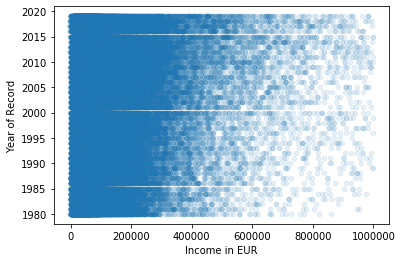

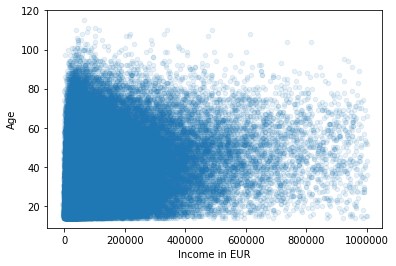

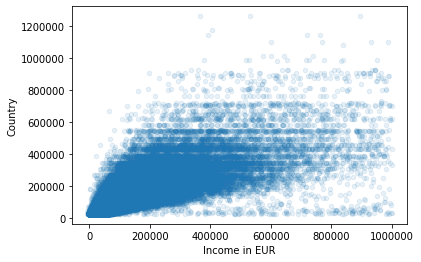

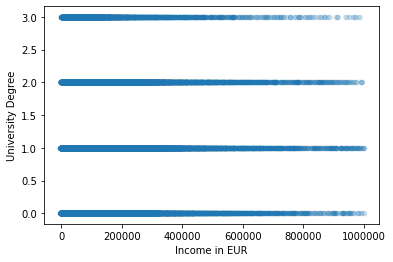

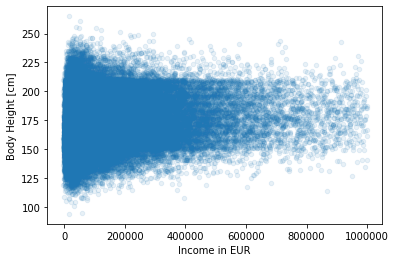

In [106]:
for i in range(len(attr) - 1):
    data.plot(kind='scatter', x='Income in EUR', y=attr[i], alpha=0.1)

In [107]:
display(HTML("<script>$('.output_scroll').removeClass('output_scroll')</script>"))

In [82]:
i=10
for dat in data:
    if i > 0: i -= 1
    else: break
    for da in data[dat]:
        if i > 0: i -= 1
        else: break
        print()
#     print(type(dat))
#     print('Hello world')